<a href="https://colab.research.google.com/github/jeon-maker/Team4_food-project/blob/main/jeon/food_detection0509.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#food detection
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
image_dir = Path('/content/drive/MyDrive/food_detection/images')


In [3]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


In [4]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

In [5]:
images = pd.concat([filepaths, labels], axis=1)

In [6]:
category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(100, random_state=1,replace=True))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [7]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/food_detection/images/p...,paella
1,/content/drive/MyDrive/food_detection/images/l...,lobster_bisque
2,/content/drive/MyDrive/food_detection/images/c...,cheesecake
3,/content/drive/MyDrive/food_detection/images/d...,dumplings
4,/content/drive/MyDrive/food_detection/images/f...,french_fries
...,...,...
7195,/content/drive/MyDrive/food_detection/images/b...,breakfast_burrito
7196,/content/drive/MyDrive/food_detection/images/g...,guacamole
7197,/content/drive/MyDrive/food_detection/images/f...,foie_gras
7198,/content/drive/MyDrive/food_detection/images/b...,baklava


In [8]:
image_df['Label'].value_counts()

paella            100
lobster_bisque    100
frozen_yogurt     100
chicken_wings     100
deviled_eggs      100
                 ... 
filet_mignon      100
lasagna           100
hot_dog           100
chocolate_cake    100
edamame           100
Name: Label, Length: 72, dtype: int64

Train Test Split


In [9]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)


In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)



Found 4032 validated image filenames belonging to 72 classes.
Found 1008 validated image filenames belonging to 72 classes.
Found 2160 validated image filenames belonging to 72 classes.


In [12]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [13]:
#""" from keras.models import Sequential"""
#""" from keras import layers"""
#""" from keras.optimizers import RMSprop"""

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [14]:

inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(72, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

Training

In [15]:

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)


Epoch 1/10
126/126 [==============================] - 1432s 11s/step - loss: 3.4157 - accuracy: 0.2001 - val_loss: 2.5353 - val_accuracy: 0.3661
Epoch 2/10
126/126 [==============================] - 161s 1s/step - loss: 2.0255 - accuracy: 0.4645 - val_loss: 2.2345 - val_accuracy: 0.4127
Epoch 3/10
126/126 [==============================] - 159s 1s/step - loss: 1.4652 - accuracy: 0.6022 - val_loss: 2.1569 - val_accuracy: 0.4474
Epoch 4/10
126/126 [==============================] - 158s 1s/step - loss: 1.1027 - accuracy: 0.7036 - val_loss: 1.9791 - val_accuracy: 0.4891
Epoch 5/10
126/126 [==============================] - 163s 1s/step - loss: 0.8208 - accuracy: 0.7808 - val_loss: 2.0573 - val_accuracy: 0.4821
Epoch 6/10
126/126 [==============================] - 161s 1s/step - loss: 0.6030 - accuracy: 0.8435 - val_loss: 2.0173 - val_accuracy: 0.5139
Epoch 7/10
126/126 [==============================] - 169s 1s/step - loss: 0.4197 - accuracy: 0.9028 - val_loss: 2.1608 - val_accuracy: 0.49

In [16]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 50.09%


In [17]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

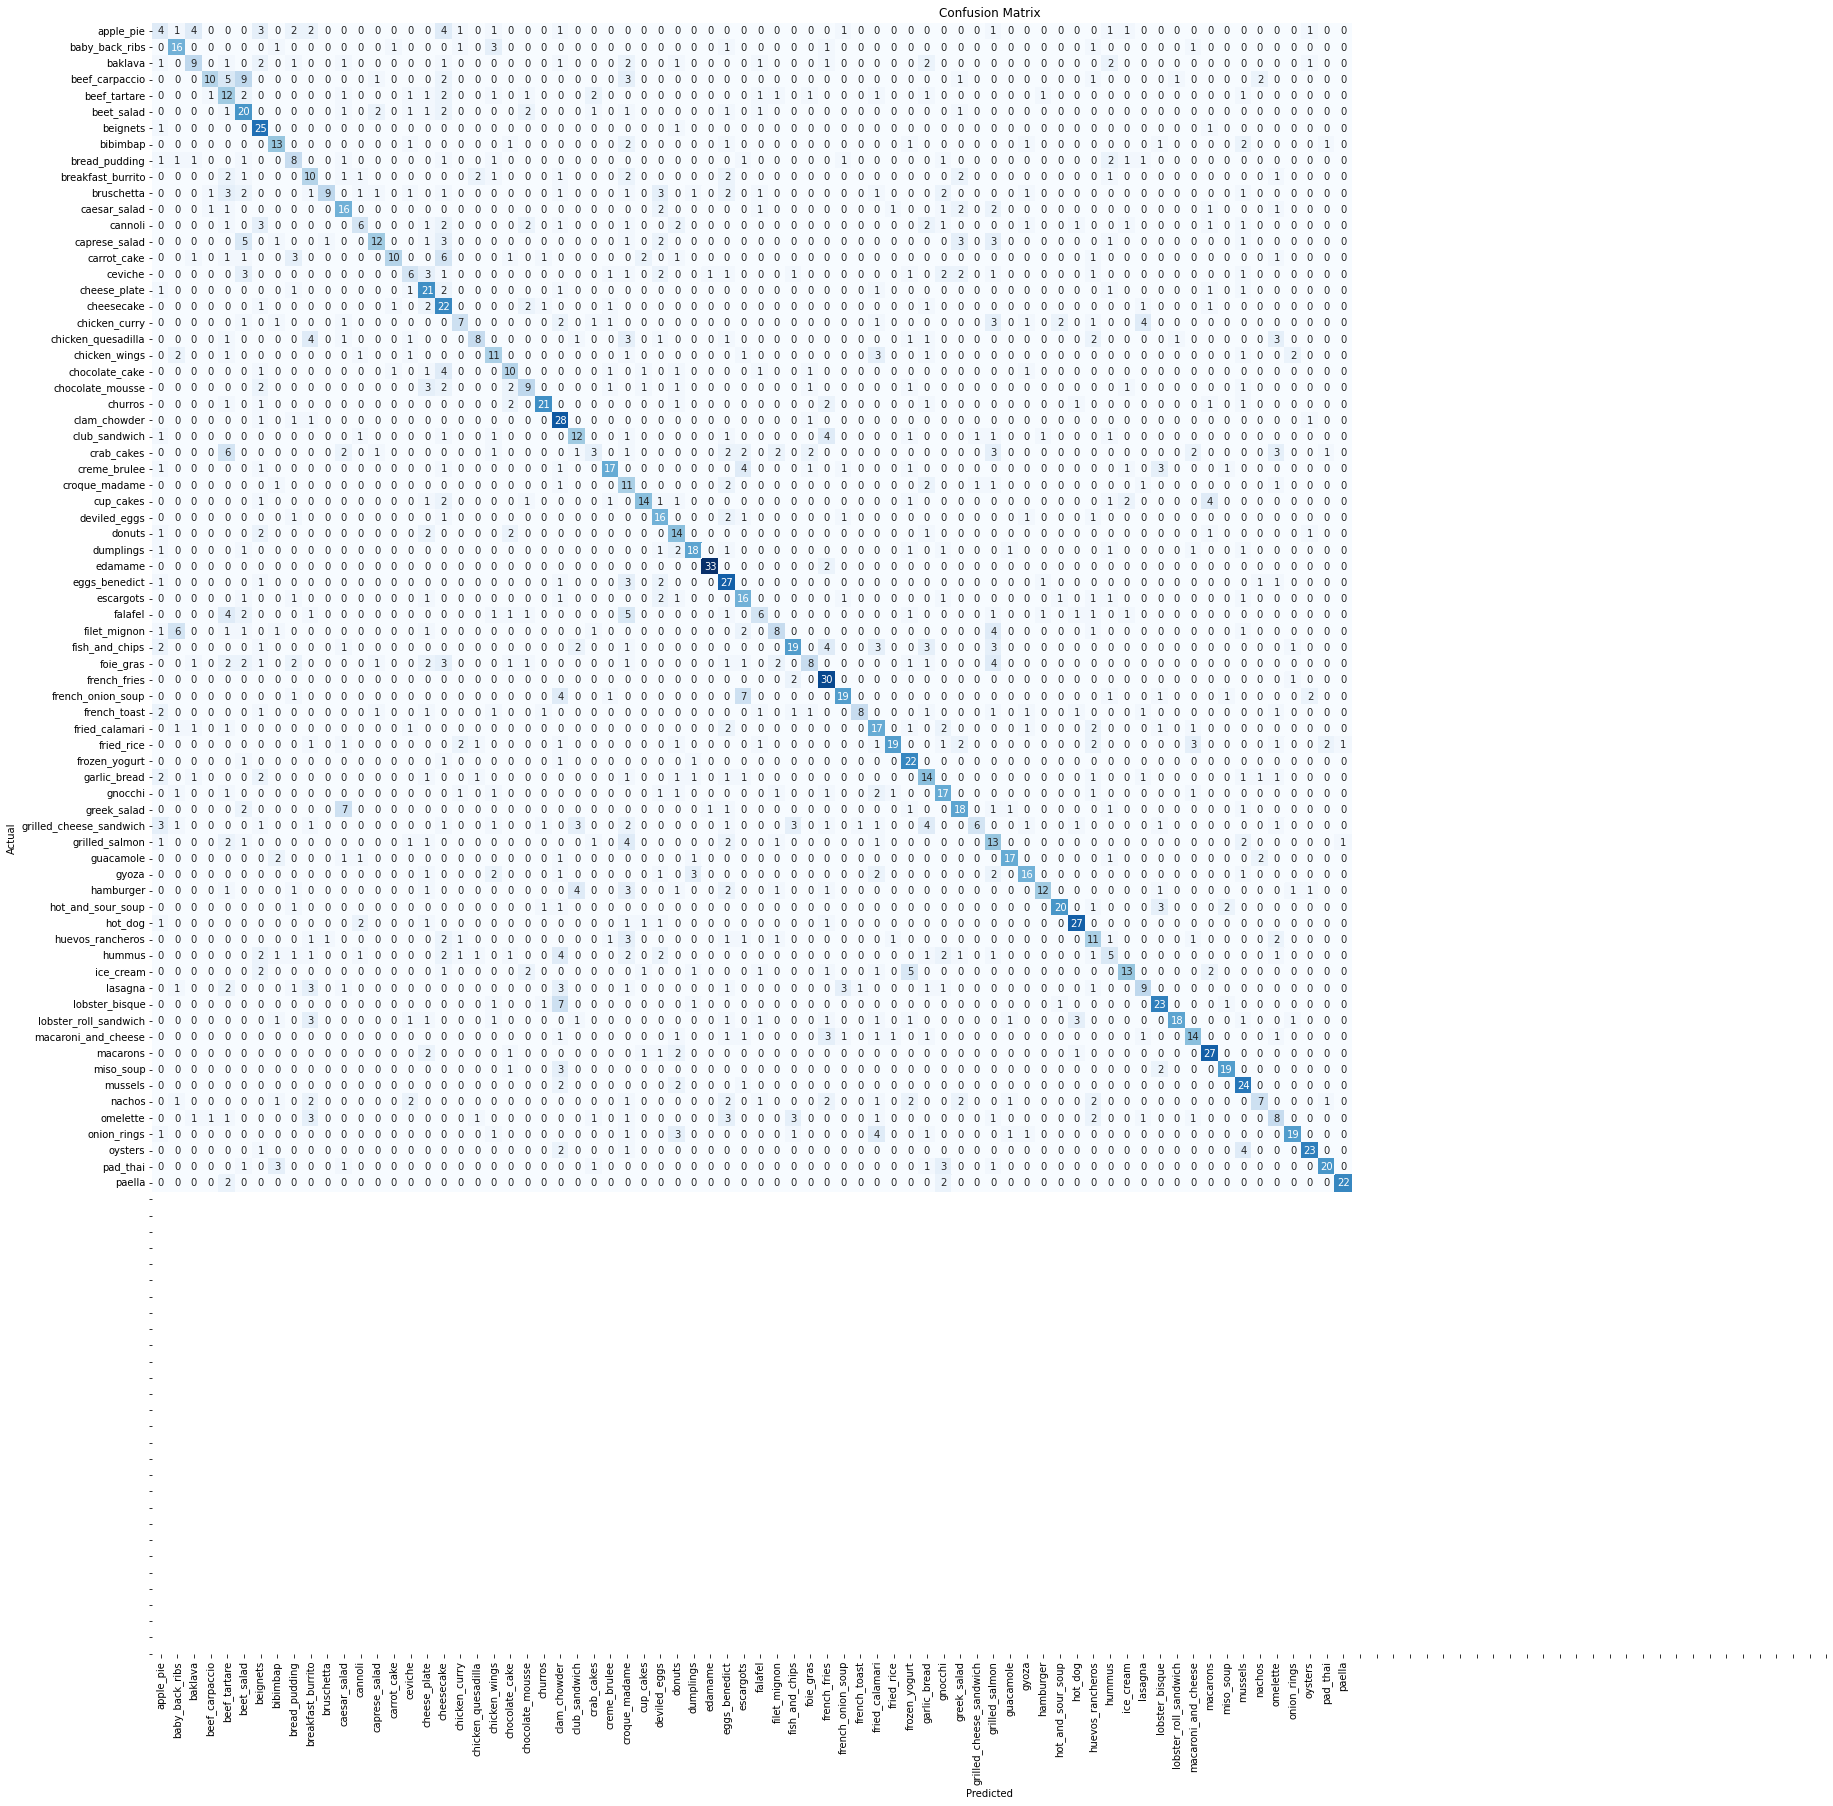

In [18]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [19]:
print("Classification Report:\n----------------------\n", clr)


Classification Report:
----------------------
                          precision    recall  f1-score   support

              apple_pie       0.15      0.14      0.15        28
         baby_back_ribs       0.52      0.62      0.56        26
                baklava       0.47      0.33      0.39        27
         beef_carpaccio       0.71      0.29      0.41        35
           beef_tartare       0.23      0.39      0.29        31
             beet_salad       0.35      0.57      0.43        35
               beignets       0.45      0.89      0.60        28
               bibimbap       0.50      0.54      0.52        24
          bread_pudding       0.32      0.36      0.34        22
      breakfast_burrito       0.29      0.37      0.33        27
             bruschetta       0.82      0.26      0.40        34
           caesar_salad       0.43      0.55      0.48        29
                cannoli       0.43      0.22      0.29        27
          caprese_salad       0.63      0.